<a href="https://colab.research.google.com/github/GeoTurkey/GMT_COURSES/blob/main/Pressure_Data_PyTorch_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN Exercises


In the exercises below you'll be asked to do the following:
* Perform standard imports, load & plot the dataset (code provided)
* Prepare data for an LSTM model
* Define the LSTM model, loss and optimization functions
* Train the model
* Evaluate the model on test data
* OPTIONAL: Plot the results

## Perform standard imports, load and plot the dataset
Run the cells below to load the libraries needed for this exercise and the Energy Production dataset, and to plot the data.

In [1]:
# RUN THIS CELL
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import datetime
from torch.autograd import Variable


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
path="https://raw.githubusercontent.com/GeoTurkey/GMT_COURSES/main/ZIMM_cod.trp"

df=pd.read_csv(path, sep=",", index_col="DateTime", parse_dates=True)
df=df.filter(["ztd"])
df

,ztd
DateTime,
2003-06-08 00:00:00,2.24634
2003-06-08 02:00:00,2.25351
2003-06-08 04:00:00,2.25532
2003-06-08 06:00:00,2.25575
2003-06-08 08:00:00,2.25258
...,...
2020-12-31 16:00:00,2.11061
2020-12-31 18:00:00,2.10295
2020-12-31 20:00:00,2.09987


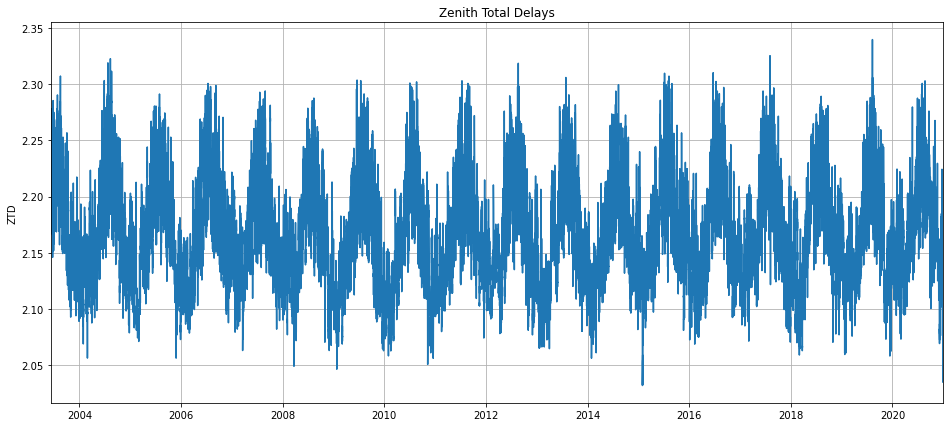

In [2]:
# RUN THIS CELL
plt.figure(figsize=(16,7))
plt.title('Zenith Total Delays')
plt.ylabel('ZTD')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['ztd'])
plt.show()

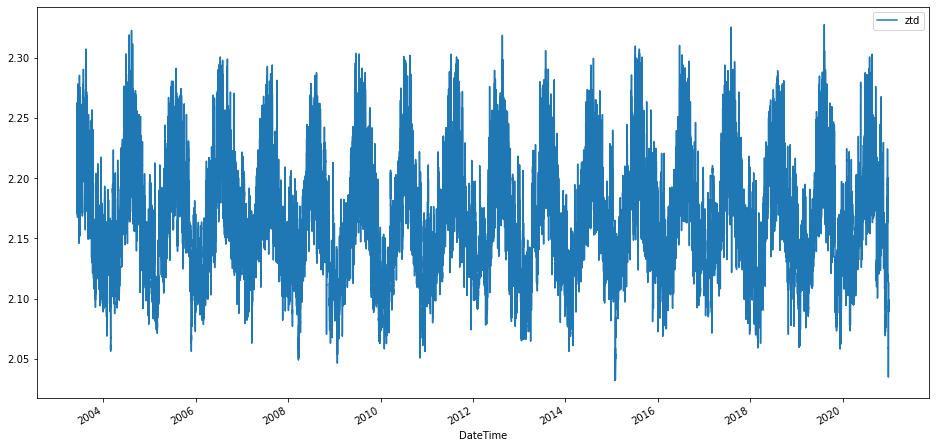

In [3]:
Q1=df["ztd"].quantile(0.20)
Q3=df["ztd"].quantile(0.80)
IQR=Q3-Q1
filter = (df['ztd'] >= Q1 - 1.5 * IQR) & (df['ztd'] <= Q3 + 1.5 *IQR)
df=df.loc[filter]
df.plot(figsize=(16,8))

In [4]:
df=df.resample("W").mean()

In [5]:
df=df.dropna()

In [6]:
len(df)

918

# Prepare the data
For the first set of exercises we'll
* divide the data into train and test sets
* normalize the training set
* prepare windowed seq/label tuples for an LSTM model

## 1. Divide the data into train and test sets
Working with a window_size of 12, divide the dataset into a sequence of 313 training records (including the window), and a test set of 12 records.

In [7]:

# DON'T WRITE HERE
y = df['ztd'].values.astype(float)

test_size = 52
train_size = len(df) - test_size
window_size = 240

train_set = y[:-test_size]
test_set = y[-test_size:]


scaler = MinMaxScaler(feature_range=(-1, 1))
train_set = scaler.fit_transform(train_set.reshape(-1,1))
test_set = scaler.transform(test_set.reshape(-1,1))

# Run the code below to check your results:
print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')
print(f'Train Shape: {train_set.shape}')
print(f'Test Shape:  {test_set.shape}')

Train: 866
Test:  52
Train Shape: (866, 1)
Test Shape:  (52, 1)


In [8]:
# Run the code below to check your results:
print(f'First item, original: {y[0]}')
print(f'First item, scaled:  {train_set[0]}')

First item, original: 2.248815
First item, scaled:  [0.95385385]


In [ ]:
# RUN THIS CELL
def sliding_windows(data, seq_length):
    Xs = []
    ys = []
    L=len(data)
    for i in range(L-seq_length):
        v = data[i:(i+seq_length)]
        Xs.append(v)
        ys.append(data[i+seq_length:i+seq_length+1,0])
    return np.array(Xs), np.array(ys)


x, y = sliding_windows(train_set, window_size)

trainX = Variable(torch.Tensor(np.array(x))).cuda()
trainY = Variable(torch.Tensor(np.array(y))).cuda()

In [ ]:
print(trainX.shape)
print(trainY.shape)

In [ ]:
# DON'T WRITE HERE
class LSTMnetwork(nn.Module):
    def __init__(self, num_features=1, input_size=1, hidden_size=1500, num_layers = 2, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)

        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size, output_size)
        
        
    def forward(self,x):
      self.hidden = (torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_().cuda(),
                     torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_().cuda())
      lstm_out, self.hidden = self.lstm(x, self.hidden)
      pred = self.linear(lstm_out[:,-1,:])
      return pred

torch.manual_seed(42)
model = LSTMnetwork().cuda()
print(model)

In [ ]:

# DON'T WRITE HERE
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# DON'T WRITE HERE
epochs = 1000
hist = np.zeros(epochs)

for i in range(epochs):
    model.train()
    # reset the parameters and hidden states
    optimizer.zero_grad()
    # apply the model
    y_pred = model(trainX)
    # update parameters
    loss = criterion(y_pred, trainY)
    hist[i]=loss.item()
    loss.backward()
    optimizer.step()

  
    # OPTIONAL print statement
    if i % 5 == 0 and i !=0:
        print("Epoch ", i, "Train Loss: {}".format(loss.item()))

In [ ]:
plt.plot(hist)


In [ ]:
future = 52
train_norm = torch.FloatTensor(train_set).view(-1)
preds = train_norm[-window_size:].tolist()


model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:]).view(1,window_size,-1).cuda()
    with torch.no_grad():
        preds.append(model(seq).item())
        
#preds[window_size:]

In [ ]:
# DON'T WRITE HERE
"""
class LSTMnetwork(nn.Module):
    def __init__(self,num_features=1, input_size=1, hidden_size_1=60, hidden_size_2 = 30, nb_layers_1 = 1, nb_layers_2 = 1, output_size=1):
        super().__init__()
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2

        
        # Add an LSTM layer:
        self.lstm_1 = nn.LSTM(input_size,hidden_size_1, nb_layers_1)
        self.lstm_2 = nn.LSTM(hidden_size_1,hidden_size_2, nb_layers_2)

        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size_2, output_size)
        
        # Initialize h0 and c0:
        self.hidden_1 = (torch.zeros(1,1,self.hidden_size_1).cuda(),
                       torch.zeros(1,1,self.hidden_size_1).cuda())
        
                # Initialize h0 and c0:
        self.hidden_2 = (torch.zeros(1,1,self.hidden_size_2).cuda(),
                       torch.zeros(1,1,self.hidden_size_2).cuda())

    def forward(self,seq):
        lstm_out_1, self.hidden_1 = self.lstm_1(
            seq.view(len(seq),1,-1), self.hidden_1)
        lstm_out_2, self.hidden_2 = self.lstm_2(
            lstm_out_1, self.hidden_2)
        pred = self.linear(lstm_out_2.view(len(seq),-1))
        return pred[-1]

model = LSTMnetwork().cuda()
print(model)

# DON'T WRITE HERE
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# DON'T WRITE HERE
epochs = 500
hist = np.zeros(epochs)

for i in range(epochs):
    for seq, y_train in train_data:
        model.train()
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden_1 = (torch.zeros(1,1,model.hidden_size_1).cuda(),
                        torch.zeros(1,1,model.hidden_size_1).cuda())
        
        model.hidden_2 = (torch.zeros(1,1,model.hidden_size_2).cuda(),
                        torch.zeros(1,1,model.hidden_size_2).cuda())
        
        # apply the model
        y_pred = model(seq)
        # update parameters
        loss = criterion(y_pred, y_train)
        hist[i]=loss.item()
        loss.backward()
        optimizer.step()

    # OPTIONAL print statement
    if i % 5 == 0 and i !=0:
      print("Epoch ", i, "Train Loss: {}".format(loss.item()))
"""

In [ ]:
# DON'T WRITE HERE
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
test_set = scaler.inverse_transform(np.array(test_set.reshape(-1, 1)))

In [ ]:
test_data = df[-test_size:]
test_data["Predictions"] = true_predictions

In [ ]:
test_data.head()

In [ ]:
test_data.plot()

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error

mae = metrics.mean_absolute_error(test_data["ztd"], test_data["Predictions"])
mse = metrics.mean_squared_error(test_data["ztd"], test_data["Predictions"])
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(test_data["ztd"], test_data["Predictions"])

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)



### Great job!